# Finding relevant genes and locations

In [1]:
library("data.table")
library("dplyr")
library("AnnotationHub")
library("GenomicRanges")
library("GenomicFeatures")
library("stringr")
library("karyoploteR", "BSgenome")
library(org.Hs.eg.db)
library(limma)
library("goseq")
library(magrittr)
library(trackViewer)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, whi

In [2]:
# VARIABLES

chr_names <- c(
    "chr1", "chr2", "chr3", "chr4", "chr5",
    "chr6", "chr7", "chr8", "chr9", "chr10",
    "chr11", "chr12", "chr13", "chr14", "chr15",
    "chr16", "chr17", "chr18", "chr19", "chr20",
    "chr21", "chr22", "chrX", "chrY", "chrM"
)

# FUNCTIONS

printf <- function(text) {
    print(text)
    flush.console()
}

get_up_DMPs <- function(DMP_data, data_source) {
    # Get up methylated in BCG 
    if (data_source == 'modkit') {
        data <- DMP_data[balanced_effect_size < 0]
    } else {
        data <- DMP_data[balanced_effect_size > 0]
    }
    return(data)
}


get_down_DMPs <- function(DMP_data, data_source) {
    # Get down methylated in BCG 
    if (data_source == 'modkit') {
        data <- DMP_data[balanced_effect_size > 0]
    } else {
        data <- DMP_data[balanced_effect_size < 0]
    }
    return(data)
}

order_my_chroms <- function(my_chrom_list) {
    chromosome_order <- c(paste0("chr", 1:22), "chrX", "chrY", "chrM")
    ordered_chromosomes <- factor(my_chrom_list, levels = chromosome_order)
    ordered_chromosomes <- sort(ordered_chromosomes)
    ordered_chromosomes <- as.character(ordered_chromosomes)
    return(ordered_chromosomes)
}

get_gene_list <- function(name_of_test, modCtype) {
    path2_output = paste0("/home/dejlu879/20250408-BEBIC_B_5hmC_dmr/pipeline_", name_of_test, "/output_data/", modCtype, "/")
    rdata_fn = paste0(path2_output, 'karyoplotting_vars.', name_of_test, '.Rdata')
    load(file = rdata_fn)

    gene_list = my_topgenes_gr$gene_id
    
    return(gene_list)
}

In [13]:
# Function to standardize metadata columns across GRanges
standardize_metadata <- function(gr, all_colnames) {
  # Fill in any missing metadata columns with NA
  missing_cols <- setdiff(all_colnames, colnames(mcols(gr)))
  for (col in missing_cols) {
    mcols(gr)[[col]] <- NA
  }
  # Reorder columns to match
  mcols(gr) <- mcols(gr)[, all_colnames]
  return(gr)
}

# function to get one gr for a test
collate_dmps_per_gene_for_one_test <- function(rdata_fn, test_desc) {
  gene_list = my_topgenes_gr$gene_id

  # Get all GRanges into a named list
  gr_list <- list(
    modkit_upDMP = modkit_upDMP_gr,
    modkit_downDMP = modkit_downDMP_gr,
    minfi_upDMP = minfi_upDMP_gr,
    minfi_downDMP = minfi_downDMP_gr
  )

  # Get the list of all metadata column names across GRanges, plus the 'source' column we will add
  all_metadata_cols <- unique(unlist(lapply(gr_list, function(gr) colnames(mcols(gr)))))
  all_metadata_cols <- unique(c(all_metadata_cols, "source"))

  # For each GRanges, subset by gene_id and add source
  subsetted_list <- lapply(names(gr_list), function(gr_name) {
    gr <- gr_list[[gr_name]]
    matched <- gr[mcols(gr)$gene_id %in% gene_list]
    if (length(matched) > 0) {
      mcols(matched)$source <- gr_name
      matched <- standardize_metadata(matched, all_metadata_cols)
      return(matched)
    } else {
      return(NULL)
    }
  })

  # Remove NULL entries (genes not found)
  subsetted_list <- Filter(Negate(is.null), subsetted_list)

  # Now safely combine into a single GRanges
  final_gr <- do.call(c, subsetted_list)
  final_gr$TestParameters <- test_desc

  return(final_gr)
}

# function to get one gr for a DMR test
collate_DMRs_per_gene <- function(dt_path) {
    
    dt = read.csv(dt_path)

    gene_list = dt$gene_id

    # get granges object ready for plotting top scoring DMPs
    gr = makeGRangesFromDataFrame(dt, keep.extra.columns = TRUE)
    
    # Remove NULL entries (genes not found)
    gr <- gr[!is.na(mcols(gr)$gene_id)]


    return(gr)
}

In [14]:
add_names_to_dmr <- function(gr) {
    seqs <- as.character(seqnames(gr))
    counts <- ave(seq_along(seqs), seqs, FUN = seq_along)
    gr$name <- paste0(gsub("chr", "", seqs), ".", counts)
    
    return(gr)
}

In [ ]:
# Do the above on each test
tests_info = c(
    "test13_mc" = "SW780 CpG 5mC",
    "test13_hmc" = "SW780 CpG 5hmC",
    "test14_mc" = "RT4 CpG 5mC",
    "test14_hmc" = "RT4 CpG 5hmC",
    "test15_mc" = "SW780 C excl. CpG 5mC",
    "test15_hmc" = "SW780 C excl. CpG 5hmC",
    "test16_mc" = "RT4 C excl. CpG 5mC",
    "test16_hmc" = "RT4 C excl. CpG 5hmC",
    "test4" = "SW780 AGG 6mA",
    "test7" = "RT4 AGG 6mA",
    "test11" = "SW780 A excl. AGG 6mA",
    "test12" = "RT4 A excl. AGG 6mA",
    "SW780_5mC_dt" = "SW780 CpG 5mC DMRs",
    "RT4_5mC_dt" = "RT4 CpG 5mC DMRs",
    "SW780_5hmC_dt" = "SW780 CpG 5hmC DMRs",
    "RT4_5hmC_dt" = "RT4 CpG 5hmC DMRs"
)

tests_to_split = c("test13_mc", "test13_hmc", "test14_mc", "test14_hmc", "test15_mc", "test15_hmc", "test16_mc", "test16_hmc")
dmr_results = c("SW780_5mC_dt", "RT4_5mC_dt", "SW780_5mC5hmC_dt", "RT4_5mC5hmC_dt")

home_d <- "/home/dejlu879/20240731-BEBIC_dmr/20240731-BEBIC_dmr"
home_d_split <- "/home/dejlu879/20250408-BEBIC_B_5hmC_dmr"

all_genes = c()
named_grs = c()

for (name_of_test in names(tests_info)) {
    print(" ")
    print("--------")
    print(paste0(name_of_test, ": ", tests_info[[name_of_test]]))
    test_desc = tests_info[[name_of_test]]

    if (name_of_test %in% tests_to_split) {
        test_num <- strsplit(name_of_test, "_")[[1]][1]
        modCtype <- strsplit(name_of_test, "_")[[1]][2]
        path2_output <- paste0(home_d_split, "/pipeline_", test_num, "/output_data/", modCtype, "/")
    } else if (name_of_test %in% dmr_results) {
        path2dt = paste0("/home/dejlu879/20250429-BEBIC_DMP_DMR/dt_csvs_of_DMRs/", name_of_test, ".csv")
        final_gr <- collate_DMRs_per_gene(path2dt)
        final_gr$TestParameters = final_gr$test_description
        final_gr$TestParameters <- gsub("BEBIC_B", "SW780 DMR", final_gr$TestParameters)
        final_gr$TestParameters <- gsub("BEBIC_C", "RT4 DMR", final_gr$TestParameters)
        final_gr = add_names_to_dmr(final_gr)
        names(final_gr) <- final_gr$name
        all_genes = c(all_genes, final_gr$gene_id)
        named_grs <- c(named_grs, setNames(list(final_gr), name_of_test))
        next
    } else {
        test_num <- name_of_test
        modCtype <- NULL
        path2_output <- paste0(home_d, "/pipeline_", test_num, "/output_data/")
    }

    rdata_fn = paste0(path2_output, "karyoplotting_vars.", test_num, ".Rdata")
    if (file.exists(rdata_fn)) {
        load(file = rdata_fn)
    } else {
        print("no data for this test")
        next
    }

    final_gr <- collate_dmps_per_gene_for_one_test(rdata_fn, test_desc)
    
    all_genes = c(all_genes, my_topgenes_gr$gene_id)

    named_grs <- c(named_grs, setNames(list(final_gr), name_of_test))
    # break
}

print(length(all_genes))
all_genes = unique(all_genes)
print(length(all_genes))

[1] " "
[1] "--------"
[1] "test13_mc: SW780 CpG 5mC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1, chr2, chr5
  - in 'y': chr16
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr2, chr5, chr16
  - in 'y': chr11, chr14, chr22
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1, chr2, chr5, chr16, chr11
  - in 'y': chr6, chr15, chr21
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] " "
[1] "--------"
[1] "test13_hmc: SW780 CpG 5hmC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr3, chr13, chr15, chr16
  - in 'y': chr4
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] " "
[1] "--------"
[1] "test14_mc: RT4 CpG 5mC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr15, chr18, chr21, chr22, chrX
  - in 'y': chr7, chr9, chr16, chr17
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr3, chr8, chr15, chr18, chr21, chrX, chr7, chr9, chr16, chr17
  - in 'y': chr5, chr14
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr3, chr8, chr18, chr21, chr22, chrX, chr7, chr9, chr17, chr5
  - in 'y': chr2
  Make sure to always combine/compare objects based on the same reference
  genome (use

[1] " "
[1] "--------"
[1] "test14_hmc: RT4 CpG 5hmC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr3, chr8, chr15, chr17, chr19
  - in 'y': chr21
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr8, chr17, chr19, chr21
  - in 'y': chr1, chr4, chr5
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr3, chr8, chr14, chr15, chr19, chr4, chr5
  - in 'y': chr16
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] " "
[1] "--------"
[1] "test15_mc: SW780 C excl. CpG 5mC"
[1] "no data for this test"
[1] " "
[1] "--------"
[1] "test15_hmc: SW780 C excl. CpG 5hmC"
[1] "no data for this test"
[1] " "
[1] "--------"
[1] "test16_mc: RT4 C excl. CpG 5mC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr15, chr18, chr21, chr22, chrX
  - in 'y': chr7, chr9, chr16, chr17
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"


[1] " "
[1] "--------"
[1] "test16_hmc: RT4 C excl. CpG 5hmC"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr15, chr18, chr21, chr22, chrX
  - in 'y': chr7, chr9, chr16, chr17
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] " "
[1] "--------"
[1] "test4: SW780 AGG 6mA"
[1] " "
[1] "--------"
[1] "test7: RT4 AGG 6mA"
[1] " "
[1] "--------"
[1] "test11: SW780 A excl. AGG 6mA"


Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr17
  - in 'y': chr8, chr9, chr20, chr21
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"


[1] " "
[1] "--------"
[1] "test12: RT4 A excl. AGG 6mA"
[1] " "
[1] "--------"
[1] "SW780_5mC_dt: SW780 CpG 5mC DMRs"
[1] " "
[1] "--------"
[1] "RT4_5mC_dt: RT4 CpG 5mC DMRs"
[1] " "
[1] "--------"
[1] "SW780_5hmC_dt: SW780 CpG 5hmC DMRs"
[1] "no data for this test"
[1] " "
[1] "--------"
[1] "RT4_5hmC_dt: RT4 CpG 5hmC DMRs"
[1] "no data for this test"
[1] 75
[1] 59


In [48]:
all_genes

[1] "IGLON5"        "IL5"           "LINC01837"     "LOC105373215" 
 [5] "LOC105373456"  "LOC124902789"  "LOFF_G0010304" "LOFF_G0010792"
 [9] "LSM14A"        "NOSIP"         "POTEM"         "SPEF2"        
[13] "SYCP2"         "ZNF114-AS1"    "ZNF235"        "ZNF283"       
[17] "ZNF329"        "CACNG6"        "DEDD2"         "FAT1"         
[21] "FNDC3B"        "KRTDAP"        "LINC01270"     "LOC105370291" 
[25] "LOC124904790"  "NALCN"         "PRKD2"         "SARS2"        
[29] "SLCO4A1"       "SNRPA1"        "TTLL9"         "ZNF444"       
[33] "ZNF813"        "FAM189A1"      "KATNAL2"       "LOFF_G0010312"
[37] "MIR570HG"      "FAM66B"        "GOLGA2P10"     "LOC124904712" 
[41] "LOFF_G0010304" "LOFF_G0010320" "LOFF_G0010340" "LOFF_G0010363"
[45] "LOFF_G0010571" "LOFF_G0010875" "NBPF6"         "KATNAL2"      
[49] "LOFF_G0010300" "MIR570HG"      "KATNAL2"       "MIR570HG"     
[53] "LOFF_G0010292" "LOFF_G0010368" "LOFF_G0010788" "LOFF_G0010571"
[57] "LOFF_G0010787" "ESF1"          "GUSBP17"       "LOC124904768" 
[61] "LOC124905154"  "LOFF_G0010368" "LOFF_G0010788" "LRRC37A3"     
[65] "MAFIP"         "ZDHHC11"       "LOFF_G0010788"

In [17]:
count = 0
all_genes = unique(all_genes)
for (gene in all_genes) {
    if (grepl("^LOFF", gene)) {
        next
    }
    if (grepl("^LOC", gene)) {
        next
    }
    # print(gene)
    count = count + 1
}
print(count)
print(length(all_genes))

[1] 38
[1] 59


In [4]:

get_main_transcript_with_regulatory_regions <- function(txdb, gene_name, upstream = 2000, downstream = 1000) {
    # Set up columns to retrieve
    columns_to_get <- c(
        "EXONCHROM", "EXONEND", "EXONID", "EXONNAME",
        "EXONRANK", "EXONSTART", "EXONSTRAND", "GENEID", "TXID"
    )

    # 1. Find all exons for the gene
    gene_exons <- select(txdb, keys = gene_name, columns = columns_to_get, keytype = "GENEID")
    # print(gene_exons)

    # 2. Count exons per transcript
    exon_counts <- table(gene_exons$TXID)

    # 3. Find TXID with most exons
    main_txid <- names(exon_counts)[which.max(exon_counts)]
    # print(main_txid)

    # 4. Pull exons by transcript
    exons_by_tx <- exonsBy(txdb, by = "tx")

    main_tx_exons <- exons_by_tx[[main_txid]]

    # Add metadata
    mcols(main_tx_exons)$TXID <- main_txid
    mcols(main_tx_exons)$GENEID <- unique(gene_exons$GENEID)
    mcols(main_tx_exons)$feature <- "exon"

    # 5. Get regulatory (promoter) regions
    # promoters_gr <- promoters(txdb, upstream = upstream, downstream = downstream, filter = c("tx_id" = main_txid))
    promoters_gr <- promoters(txdb, upstream = upstream, downstream = downstream, filter = c("tx_id" = main_txid))
    # Reduce overlapping promoter regions
    promoters_gr <- reduce(promoters_gr)

    # Add metadata to promoter regions
    mcols(promoters_gr)$TXID <- main_txid
    mcols(promoters_gr)$GENEID <- unique(gene_exons$GENEID)
    mcols(promoters_gr)$feature <- "regulatory"

    # Add metadata to promoter regions
    mcols(promoters_gr)$TXID <- main_txid
    mcols(promoters_gr)$GENEID <- unique(gene_exons$GENEID)
    mcols(promoters_gr)$feature <- "regulatory"

    # 6. Combine exons + regulatory regions
    # final_gr <- c(main_tx_exons, promoters_gene_reduced)
    final_gr <- c(main_tx_exons, promoters_gr)

    return(final_gr)
}


https://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/GenomicRanges/html/intra-range-methods.html

promoters returns an object of the same type and length as x containing promoter ranges. Promoter ranges extend around the transcription start site (TSS) which is defined as start(x). The upsteam and downstream arguments define the number of nucleotides in the 5' and 3' direction, respectively. The full range is defined as,

(start(x) - upstream) to (start(x) + downstream - 1).

Ranges on the * strand are treated the same as those on the + strand. When no seqlengths are present in x, it is possible to have non-positive start values in the promoter ranges. This occurs when (TSS - upstream) < 1. In the equal but opposite case, the end values of the ranges may extend beyond the chromosome end when (TSS + downstream + 1) > 'chromosome end'. When seqlengths are not NA the promoter ranges are kept within the bounds of the defined seqlengths.


In [ ]:
# Annotation file
annotations_T2T_fp = "/home/dejlu879/refs/T2T/chm13v2.0_RefSeq_Liftoff_v5.2.gff3.gz"
# Extract genes from the TxDb
annotations_T2T = txdbmaker::makeTxDbFromGFF(annotations_T2T_fp)
genes_txdb <- genes(annotations_T2T) # 'txdb' is TxDb object

Import genomic features from the file as a GRanges object ... 


OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .extract_transcripts_from_GRanges(tx_IDX, gr, mcols0$type, mcols0$ID, :
"some transcripts have no "transcript_id" attribute ==> their name
  ("tx_name" column in the TxDb object) was set to NA"
Warning message in .extract_transcripts_from_GRanges(tx_IDX, gr, mcols0$type, mcols0$ID, :
"the transcript names ("tx_name" column in the TxDb object) imported
  from the "transcript_id" attribute are not unique"
Warning message in .find_exon_cds(exons, cds):
"The following transcripts have exons that contain more than one CDS
  (only the first CDS was kept for each exon): NM_001134939.1,
  NM_001172437.2, NM_001184961.1, NM_001301020.1, NM_001301302.1,
  NM_001301371.1, NM_002537.3, NM_004152.3, NM_015068.3, NM_016178.2"
OK



In [40]:

suppressWarnings({
    # Your code here
    log(-1) # This would normally generate a warning

    gene_description_list <- list()

    for (gene in all_genes) {
        combined_gene_gr <- GRanges()

        for (name in names(named_grs)) {
            gr <- named_grs[[name]]
            gene_gr <- gr[gr$gene_id == gene]
            combined_gene_gr <- c(combined_gene_gr, gene_gr)
        }

        # Optional: filter metadata columns with all NA
        if (length(mcols(combined_gene_gr)) > 0) {
            mcols(combined_gene_gr) <- mcols(combined_gene_gr)[, colSums(!is.na(mcols(combined_gene_gr))) > 0, drop = FALSE]
        }

        ranges(combined_gene_gr) <- IRanges(start(combined_gene_gr), width = 1)

        # Extract a single description (adjust logic if multiple)
        description <- unique(combined_gene_gr$gene_description)
        description <- description[!is.na(description)]

        gene_description_list[[gene]] <- data.frame(
            gene = gene,
            description = if (length(description) > 0) paste(description, collapse = "; ") else NA
        )
        # break
    }

    gene_descriptions <- do.call(rbind, gene_description_list)
})

gene_descriptions

,gene,description
,<chr>,<chr>
IGLON5,IGLON5,IgLON family member 5
IL5,IL5,interleukin 5
LINC01837,LINC01837,long intergenic non-protein coding RNA 1837
LOC105373215,LOC105373215,uncharacterized LOC105373215
LOC105373456,LOC105373456,uncharacterized LOC105373456
LOC124902789,LOC124902789,uncharacterized LOC124902789
LOFF_G0010304,LOFF_G0010304,"RNA, 45S pre-ribosomal 2"
LOFF_G0010792,LOFF_G0010792,rRNA
LSM14A,LSM14A,LSM14A mRNA processing body assembly factor


In [ ]:
# promoters defined as 2000bp upstream of TSS, + 1000bp downstream of TSS
# Plotted the transcripts with the most number of exons

suppressWarnings({
  # Your code here
  log(-1)  # This would normally generate a warning

    for (gene in all_genes) {
        # for (gene in c("CASZ1")) {
        # if (gene != "LOC105373215") {
        #     next
        # }

        # Actual code
        # if (gene != "CASZ1") {
        #     next
        # }

        print(paste0("------- Processing ", gene, " -------"))
        if (grepl("^LOC", gene)) {
            print(paste0("  skipping ", gene))
            next
        } else if (grepl("^LOFF", gene)) {
            print(paste0("  skipping ", gene))
            next
        }

        combined_gene_gr <- GRanges() # initialize an empty GRanges
        for (name in names(named_grs)) {
            # print(name)
            gr <- named_grs[[name]]
            # cat("Getting data from:", name, "\n")

            gene_gr = gr[gr$gene_id == gene]

            # Combine with existing
            combined_gene_gr <- c(combined_gene_gr, gene_gr)
            mcols(combined_gene_gr) <- mcols(combined_gene_gr)[, colSums(!is.na(mcols(combined_gene_gr))) > 0]
            ranges(combined_gene_gr) <- IRanges(start(combined_gene_gr), width = 1)
        }
        
        # print(combined_gene_gr)
        # combined_gene_gr$test_description <- gsub("C of ", "", combined_gene_gr$test_description)
        combined_gene_gr$TestParameters <- gsub("C of ", "", combined_gene_gr$TestParameters)
        # print(combined_gene_gr)
        
        # Get colour for modkit vs minfi
        combined_gene_gr$color <- ifelse(grepl("modkit", combined_gene_gr$source), "#aa46e9",
            ifelse(grepl("minfi", combined_gene_gr$source), "#d73c3c", NA)
        )
        # Get shape depending on if up or down meth
        combined_gene_gr$shape <- ifelse(grepl("up", combined_gene_gr$source), "triangle_point_up",
            ifelse(grepl("down", combined_gene_gr$source), "triangle_point_down", NA)
        )
        # Change height to reflect effect size
        names(mcols(combined_gene_gr))[names(mcols(combined_gene_gr)) == "score"] <- "significance_score"
        # names(mcols(combined_gene_gr))[names(mcols(combined_gene_gr)) == "balanced_effect_size"] <- "score"
        combined_gene_gr$score = abs(combined_gene_gr$balanced_effect_size)*100
        # combined_gene_gr$names = combined_gene_gr$TestParameters
        combined_gene_gr$label.parameter.label <- combined_gene_gr$TestParameters
        names(combined_gene_gr) <- combined_gene_gr$name
        # combined_gene_gr$label.parameter.rot <- 45


        # print(paste0("DMR data:"))
        # print(combined_gene_gr)

        gene_features = get_main_transcript_with_regulatory_regions(txdb = annotations_T2T, gene_name = gene)

        # Add elements to gene_features
        mcols(gene_features)$height <- NA_real_  # initialize
        mcols(gene_features)$height[mcols(gene_features)$feature == "exon"] <- 0.05
        mcols(gene_features)$height[mcols(gene_features)$feature == "regulatory"] <- 0.02

        mcols(gene_features)$color <- NA_real_  # initialize
        mcols(gene_features)$color[mcols(gene_features)$feature == "exon"] <- "lightblue"
        mcols(gene_features)$color[mcols(gene_features)$feature == "regulatory"] <- "orange"
        mcols(gene_features)$fill <- NA_real_ # initialize
        mcols(gene_features)$fill[mcols(gene_features)$feature == "exon"] <- "lightblue"
        mcols(gene_features)$fill[mcols(gene_features)$feature == "regulatory"] <- "orange"

        mcols(gene_features)$names <- NA_real_ # initialize
        mcols(gene_features)$names[mcols(gene_features)$feature == "exon"] <- "Exon"
        mcols(gene_features)$names[mcols(gene_features)$feature == "regulatory"] <- "Regulatory"

        # Order gene_features
        gene_features = gene_features[order(seqnames(gene_features), start(gene_features)), ]

        # print(gene_features)
        
        # get x_axis
        round_down <- function(x, base = 500) {
            floor(x / base) * base
        }
        round_up <- function(x, base = 500) {
            ceiling(x / base) * base
        }


        all_locs = c(start(gene_features), end(gene_features))
        min_xaxis = min(all_locs)
        max_xaxis = max(all_locs)
        # Round both to the nearest 200
        start_rounded <- round_down(min_xaxis)
        end_rounded <- round_up(max_xaxis)

        x_axis = seq(from = start_rounded, to = end_rounded, by = 2000)

        plot_filename = paste0(getwd(), "/plots/", gene, ".lolliplot.png")
        png(plot_filename, width = 1200, height = 830, res = 150)
        lolliplot(combined_gene_gr, gene_features,
            ylab = "Effect Size", xaxis = x_axis, legend = legend,
        )
        grid.text(paste0("Gene: ", gene), x = .5, y = 0.98, just = "top")
        dev.off()

        # Define the region you want to zoom in on
        data_point_gr = reduce(combined_gene_gr)
        zoom_range <- GRanges(
            seqnames(data_point_gr)[1], IRanges(start(data_point_gr)[1] - 10, end(data_point_gr)[1] + 10)
        ) # example exon
        plot_filename <- paste0(getwd(), "/plots/", gene, ".lolliplot.zoom.png")
        # Wrap the plotting in tryCatch
        tryCatch({
            png(plot_filename, width = 1200, height = 830, res = 150)
            lolliplot(combined_gene_gr, gene_features, ranges = zoom_range, ylab = "Effect Size")
            grid.text(paste0("Gene: ", gene), x = .5, y = 0.98, just = "top")
            dev.off()
        }, error = function(e) {
            message("Skipping zoom plot for ", gene, ": ", conditionMessage(e))
            if (dev.cur() != 1) dev.off()  # Ensure device is closed
            if (file.exists(plot_filename)) file.remove(plot_filename)  # Remove partial file
        })
        # break
    }
})

[1] "------- Processing IGLON5 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing IL5 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for IL5: subscript is out of bounds



[1] "------- Processing LINC01837 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for LINC01837: subscript is out of bounds



[1] "------- Processing LOC105373215 -------"
[1] "  skipping LOC105373215"
[1] "------- Processing LOC105373456 -------"
[1] "  skipping LOC105373456"
[1] "------- Processing LOC124902789 -------"
[1] "  skipping LOC124902789"
[1] "------- Processing LOFF_G0010304 -------"
[1] "  skipping LOFF_G0010304"
[1] "------- Processing LOFF_G0010792 -------"
[1] "  skipping LOFF_G0010792"
[1] "------- Processing LSM14A -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for LSM14A: subscript is out of bounds



[1] "------- Processing NOSIP -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for NOSIP: subscript is out of bounds



[1] "------- Processing POTEM -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing SPEF2 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for SPEF2: subscript is out of bounds



[1] "------- Processing SYCP2 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for SYCP2: subscript is out of bounds



[1] "------- Processing ZNF114-AS1 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZNF114-AS1: subscript is out of bounds



[1] "------- Processing ZNF235 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZNF235: subscript is out of bounds



[1] "------- Processing ZNF283 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing ZNF329 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZNF329: subscript is out of bounds



[1] "------- Processing CACNG6 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for CACNG6: subscript is out of bounds



[1] "------- Processing DEDD2 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing FAT1 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing FNDC3B -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for FNDC3B: subscript is out of bounds



[1] "------- Processing KRTDAP -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing LINC01270 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for LINC01270: subscript is out of bounds



[1] "------- Processing LOC105370291 -------"
[1] "  skipping LOC105370291"
[1] "------- Processing LOC124904790 -------"
[1] "  skipping LOC124904790"
[1] "------- Processing NALCN -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for NALCN: subscript is out of bounds



[1] "------- Processing PRKD2 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for PRKD2: subscript is out of bounds



[1] "------- Processing SARS2 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for SARS2: subscript is out of bounds



[1] "------- Processing SLCO4A1 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing SNRPA1 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for SNRPA1: subscript is out of bounds



[1] "------- Processing TTLL9 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for TTLL9: subscript is out of bounds



[1] "------- Processing ZNF444 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZNF444: subscript is out of bounds



[1] "------- Processing ZNF813 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZNF813: subscript is out of bounds



[1] "------- Processing FAM189A1 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for FAM189A1: subscript is out of bounds



[1] "------- Processing KATNAL2 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for KATNAL2: subscript is out of bounds



[1] "------- Processing LOFF_G0010312 -------"
[1] "  skipping LOFF_G0010312"
[1] "------- Processing MIR570HG -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for MIR570HG: subscript is out of bounds



[1] "------- Processing FAM66B -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for FAM66B: subscript is out of bounds



[1] "------- Processing GOLGA2P10 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for GOLGA2P10: subscript is out of bounds



[1] "------- Processing LOC124904712 -------"
[1] "  skipping LOC124904712"
[1] "------- Processing LOFF_G0010320 -------"
[1] "  skipping LOFF_G0010320"
[1] "------- Processing LOFF_G0010340 -------"
[1] "  skipping LOFF_G0010340"
[1] "------- Processing LOFF_G0010363 -------"
[1] "  skipping LOFF_G0010363"
[1] "------- Processing LOFF_G0010571 -------"
[1] "  skipping LOFF_G0010571"
[1] "------- Processing LOFF_G0010875 -------"
[1] "  skipping LOFF_G0010875"
[1] "------- Processing NBPF6 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for NBPF6: subscript is out of bounds



[1] "------- Processing LOFF_G0010300 -------"
[1] "  skipping LOFF_G0010300"
[1] "------- Processing LOFF_G0010292 -------"
[1] "  skipping LOFF_G0010292"
[1] "------- Processing LOFF_G0010368 -------"
[1] "  skipping LOFF_G0010368"
[1] "------- Processing LOFF_G0010788 -------"
[1] "  skipping LOFF_G0010788"
[1] "------- Processing LOFF_G0010787 -------"
[1] "  skipping LOFF_G0010787"
[1] "------- Processing ESF1 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ESF1: subscript is out of bounds



[1] "------- Processing GUSBP17 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing LOC124904768 -------"
[1] "  skipping LOC124904768"
[1] "------- Processing LOC124905154 -------"
[1] "  skipping LOC124905154"
[1] "------- Processing LRRC37A3 -------"


'select()' returned 1:many mapping between keys and columns



[1] "------- Processing MAFIP -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for MAFIP: subscript is out of bounds



[1] "------- Processing ZDHHC11 -------"


'select()' returned 1:many mapping between keys and columns

Skipping zoom plot for ZDHHC11: subscript is out of bounds



[1] "------- Processing CASZ1 -------"


'select()' returned 1:many mapping between keys and columns



# GO and KEGG

Groups to analyse:  
- all of them together
- A mods up
- A mods down
- hmC mods up
- hmC down
- mC mods up
- mC mods down

In [22]:
genes_from_all_tests_geneIDs = data.frame()
genes_from_all_tests = c()
genes_from_Amods_up = c()
genes_from_Amods_down = c()
genes_from_hmCmods_up= c()
genes_from_hmCmods_down = c()
genes_from_mCmods_up= c()
genes_from_mCmods_down = c()

for (name in names(named_grs)) {
    print(name)
    gr <- named_grs[[name]]
    
    # Convert WASH9P to 100996442 in gene_id column
    mcols(gr)$EntrezID[mcols(gr)$EntrezID == "WASH9P"] <- "100996442"

    # Extract ENTREZID for all rows
    all_genes <- mcols(gr)$EntrezID
    genes_from_all_tests <- c(genes_from_all_tests, na.omit(all_genes))
    # Extract gene_id for all rows
    df <- data.frame(
        gene_id = mcols(gr)$gene_id,
        EntrezID = mcols(gr)$EntrezID
    )

    # Define shorthand
    desc <- mcols(gr)$source
    modtype <- mcols(gr)$TestParameters

    # Filter and extract based on combined conditions
    amods_up <- na.omit(mcols(gr)[grepl("up", desc, ignore.case = TRUE) & grepl("6mA", modtype), "EntrezID"])
    amods_down <- na.omit(mcols(gr)[grepl("down", desc, ignore.case = TRUE) & grepl("6mA", modtype), "EntrezID"])
    
    hmcmods_up <- na.omit(mcols(gr)[grepl("up", desc, ignore.case = TRUE) & grepl("5hmC", modtype), "EntrezID"])
    hmcmods_down <- na.omit(mcols(gr)[grepl("down", desc, ignore.case = TRUE) & grepl("5hmC", modtype), "EntrezID"])
    
    mcmods_up <- na.omit(mcols(gr)[grepl("up", desc, ignore.case = TRUE) & grepl("5mC", modtype), "EntrezID"])
    mcmods_down <- na.omit(mcols(gr)[grepl("down", desc, ignore.case = TRUE) & grepl("5mC", modtype), "EntrezID"])
    
    # Add to specific gene lists
    genes_from_Amods_up <- c(genes_from_Amods_up, amods_up)
    genes_from_Amods_down <- c(genes_from_Amods_down, amods_down)
    genes_from_hmCmods_up <- c(genes_from_hmCmods_up, hmcmods_up)
    genes_from_hmCmods_down <- c(genes_from_hmCmods_down, hmcmods_down)
    genes_from_mCmods_up <- c(genes_from_mCmods_up, mcmods_up)
    genes_from_mCmods_down <- c(genes_from_mCmods_down, mcmods_down)

    # Add all found genes from the above to the master list
    genes_from_all_tests <- c(genes_from_all_tests, amods_up, amods_down, hmcmods_up, hmcmods_down, mcmods_up, mcmods_down)

    # add to geneid df
    genes_from_all_tests_geneIDs <- rbind(genes_from_all_tests_geneIDs, df)
}

# Deduplicate everything
genes_from_all_tests <- unique(genes_from_all_tests)
genes_from_Amods_up <- unique(genes_from_Amods_up)
genes_from_Amods_down <- unique(genes_from_Amods_down)
genes_from_hmCmods_up <- unique(genes_from_hmCmods_up)
genes_from_hmCmods_down <- unique(genes_from_hmCmods_down)
genes_from_mCmods_up <- unique(genes_from_mCmods_up)
genes_from_mCmods_down <- unique(genes_from_mCmods_down)


[1] "test13_mc"
[1] "test13_hmc"
[1] "test14_mc"
[1] "test14_hmc"
[1] "test16_mc"
[1] "test16_hmc"
[1] "test4"
[1] "test7"
[1] "test11"
[1] "test12"


In [50]:
print(genes_from_Amods_up)
print(genes_from_Amods_down)
print(genes_from_hmCmods_up)
print(genes_from_hmCmods_down)
print(genes_from_mCmods_up)
print(genes_from_mCmods_down)

[1] "110255164" "100049076" "374819"    "727764"    "124905154" "110255163"
[1] "106631780" "106631778" "110255163" "79844"     "124904768" "51575"    
 [1] "64778"     "105370291" "259232"    "6627"      "388533"    "54938"    
 [7] "124904790" "162989"    "25865"     "59285"     "164395"    "100128890"
[13] "106631779" "124904712" "653149"    "80154"     "83473"    
[1] "2195"   "55311"  "284751" "28231"  "126017" "440993"
 [1] "105373215" "105373456" "79925"     "3567"      "402665"    "10388"    
 [7] "124902789" "106631779" "105372363" "26065"     "284349"    "79673"    
[13] "83473"    
[1] "51070"     "641455"    "9310"      "105372429" "440993"    "23359"    


In [59]:
genes_from_all_tests_geneIDs

gene_id,EntrezID
<chr>,<chr>
LOC105373215,105373215
LOC105373456,105373456
SPEF2,79925
IL5,3567
IGLON5,402665
SYCP2,10388
NOSIP,51070
LOC124902789,124902789
LOFF_G0010304,106631779


In [ ]:
get_go_and_kegg <- function(ENTREZ_gene_list, group_name) {
    ################ Get GO annotations ################
    go_path = paste0(group_name, ".go_annotation_results.tsv")
    goana_raw_result = goana(ENTREZ_gene_list)
    goana_result = goana_raw_result[goana_raw_result$DE != 0, ]
    goana_sig_result = goana_result[goana_result$P.DE < 0.05, ]
    write.table(goana_sig_result, file = go_path, sep = "\t", quote = FALSE)
    # get input for gofigure
    # goana_sig_result <- rename(goana_sig_result, all_of(c(
        # "GOterm" = "Term", "enrichment_P-value" = "P.DE", "NumGenes" = "DE"
    # )))
    print(head(goana_sig_result))
    goana_sig_result$Term = NULL
    goana_sig_result$Ont = NULL
    goana_sig_result$N = NULL
    setcolorder(goana_sig_result, c("P.DE", "DE"))
    go_path = paste0(group_name, ".go_figure.tsv")
    write.table(goana_sig_result, file = go_path, sep = "\t", quote = FALSE, col.names = FALSE)


    ################ Get KEGG annotations ################
    kegg_path = paste0(group_name, ".kegg_annotation_results.tsv")
    kegga_raw_result = kegga(ENTREZ_gene_list)
    kegga_result = kegga_raw_result[kegga_raw_result$DE != 0, ]
    kegga_sig_result = kegga_result[kegga_result$P.DE < 0.05, ]
    write.table(kegga_sig_result, file = kegg_path, sep = '\t', quote = FALSE)
}


In [135]:
get_go_and_kegg(ENTREZ_gene_list = genes_from_all_tests, group_name = "all_tests")
get_go_and_kegg(ENTREZ_gene_list = genes_from_Amods_up, group_name = "Amods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_Amods_down, group_name = "Amods_down")
get_go_and_kegg(ENTREZ_gene_list = genes_from_hmCmods_up, group_name = "hmCmods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_hmCmods_down, group_name = "hmCmods_down")
get_go_and_kegg(ENTREZ_gene_list = genes_from_mCmods_up, group_name = "mCmods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_mCmods_down, group_name = "mCmods_down")

                                                   Term Ont    N DE       P.DE
GO:0002764 immune response-regulating signaling pathway  BP  586  5 0.01899490
GO:0002253                activation of immune response  BP  592  5 0.01975576
GO:0032101  regulation of response to external stimulus  BP 1150  7 0.03090216
GO:0048584  positive regulation of response to stimulus  BP 2421 11 0.04938087
GO:0034097                         response to cytokine  BP  977  6 0.04320645
GO:1901652                          response to peptide  BP  992  6 0.04595844
                                                  Term Ont   N DE       P.DE
GO:0001539 cilium or flagellum-dependent cell motility  BP 218  1 0.02082729
GO:0003341                             cilium movement  BP 258  1 0.02462501
GO:0007018                  microtubule-based movement  BP 480  1 0.04556825
GO:0060285              cilium-dependent cell motility  BP 218  1 0.02082729
GO:0060294   cilium movement involved in cell motility  BP 215

In [67]:
all_test_topGO = topGO(goana(genes_from_all_tests), number = Inf)

all_test_topGO = all_test_topGO[all_test_topGO$P.DE < 0.01, ]
all_test_topGO

,Term,Ont,N,DE,P.DE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
GO:0003412,establishment of epithelial cell apical/basal polarity involved in camera-type eye morphogenesis,BP,1,1,0.001392557
GO:0070158,mitochondrial seryl-tRNA aminoacylation,BP,1,1,0.001392557
GO:0005137,interleukin-5 receptor binding,MF,2,1,0.002783242
GO:0045645,positive regulation of eosinophil differentiation,BP,2,1,0.002783242
GO:0045643,regulation of eosinophil differentiation,BP,2,1,0.002783242
GO:0004828,serine-tRNA ligase activity,MF,2,1,0.002783242
GO:0006434,seryl-tRNA aminoacylation,BP,2,1,0.002783242
GO:0060294,cilium movement involved in cell motility,BP,215,3,0.003252941
GO:0003676,nucleic acid binding,MF,4365,13,0.003316746


In [ ]:
# get top go and kegg

get_go_and_kegg <- function(ENTREZ_gene_list, group_name) {
    ################ Get GO annotations ################
    # go_path = paste0(group_name, ".go_annotation_results.tsv")
    goana_raw_result = goana(ENTREZ_gene_list)
    goana_result = goana_raw_result[goana_raw_result$DE != 0, ]
    goana_sig_result = goana_result[goana_result$P.DE < 0.05, ]
    # write.table(goana_sig_result, file = go_path, sep = "\t", quote = FALSE)

    goana_sig_result$Term = NULL
    goana_sig_result$Ont = NULL
    goana_sig_result$N = NULL
    setcolorder(goana_sig_result, c("P.DE", "DE"))
    go_path = paste0(group_name, ".go_figure.tsv")
    # write.table(goana_sig_result, file = go_path, sep = "\t", quote = FALSE, col.names = FALSE)


    ################ Get KEGG annotations ################
    kegg_path = paste0(group_name, ".kegg_annotation_results.tsv")
    kegga_raw_result = kegga(ENTREZ_gene_list)
    kegga_result = kegga_raw_result[kegga_raw_result$DE != 0, ]
    kegga_sig_result = kegga_result[kegga_result$P.DE < 0.05, ]
    # write.table(kegga_sig_result, file = kegg_path, sep = '\t', quote = FALSE)
}

#### KEGG

In [1]:
library(clusterProfiler)
library(ggplot2)



clusterProfiler v4.14.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu, Li-Gen Wang, Yanyan Han and Qing-Yu He.
clusterProfiler: an R package for comparing biological themes among
gene clusters. OMICS: A Journal of Integrative Biology. 2012,
16(5):284-287


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [2]:
bubble_df_kegg <- data.frame()
groups = c("all_tests", "Amods_up", "Amods_down", "hmCmods_up", "hmCmods_down", "mCmods_up", "mCmods_down")
for (group_name in groups) {
    kegg_path = paste0(group_name, ".kegg_annotation_results.tsv")
    kegg_results = read.csv(kegg_path, sep = "\t")
    print(dim(kegg_results))
    if (dim(kegg_results)[1] == 0) {
        next
    }
    kegg_results$GeneRatio <- kegg_results$DE / kegg_results$N
    kegg_results$Group <- group_name
    bubble_df_kegg <- rbind(bubble_df_kegg, kegg_results)
}
bubble_df_kegg

[1] 6 4
[1] 0 4
[1] 1 4
[1] 7 4
[1] 4 4
[1] 11  4
[1] 4 4


,Pathway,N,DE,P.DE,GeneRatio,Group
,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
hsa04360,Axon guidance,184,2,0.040278987,0.01086957,all_tests
hsa04380,Osteoclast differentiation,143,2,0.025314879,0.01398601,all_tests
hsa04658,Th1 and Th2 cell differentiation,93,2,0.011218911,0.02150538,all_tests
hsa04660,T cell receptor signaling pathway,122,2,0.018797512,0.01639344,all_tests
hsa04662,B cell receptor signaling pathway,91,2,0.010760737,0.02197802,all_tests
hsa04921,Oxytocin signaling pathway,155,3,0.002268424,0.01935484,all_tests
hsa04623,Cytosolic DNA-sensing pathway,83,1,0.009712146,0.01204819,Amods_down
hsa043801,Osteoclast differentiation,143,2,0.011457845,0.01398601,hmCmods_up
hsa046581,Th1 and Th2 cell differentiation,93,2,0.004981052,0.02150538,hmCmods_up


In [ ]:
# Replace "old" with "new" in column 'your_column'
bubble_df_kegg_sig$Group <- gsub("all_tests", "All Contexts", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig$Group <- gsub("Amods_down", "6mA Down", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig$Group <- gsub("hmCmods_up", "5hmC Up", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig$Group <- gsub("hmCmods_down", "5hmC Down", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig$Group <- gsub("mCmods_up", "5mC Up", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig$Group <- gsub("mCmods_down", "5mC Down", bubble_df_kegg_sig$Group)
bubble_df_kegg_sig

#### Get genes associated with pathways

In [148]:
genes_from_all_tests_geneIDs <- unique(genes_from_all_tests_geneIDs)

dim(genes_from_all_tests_geneIDs)
head(genes_from_all_tests_geneIDs)

[1] 104   2

,gene_id,EntrezID
,<chr>,<chr>
1,LOC105373215,105373215
2,LOC105373456,105373456
3,SPEF2,79925
4,IL5,3567
5,IGLON5,402665
6,SYCP2,10388


In [ ]:
group_names = c("All tests", "Increased 6mA", "Decreased 6mA", "Increased 5hmC", "Decreased 5hmC", "Increased 5mC", "Decreased 5mC")
groups = list(genes_from_all_tests, genes_from_Amods_up, genes_from_Amods_down, genes_from_hmCmods_up, genes_from_hmCmods_down, genes_from_mCmods_up, genes_from_mCmods_down)

results_df <- data.frame()

for (i in seq_along(group_names)) {
  group_name <- group_names[i]
  #   if (group_name == "All tests") {
  #     next
  #   }
  input_df <- groups[[i]]

  print(group_name)
  print(input_df)

  for (go_key in rownames(bubble_df_go)) {
    skip <- FALSE
    go_desc <- bubble_df_go[go_key, "Term"]
    x <- org.Hs.egGO2ALLEGS

    # try the risky assignment
    tryCatch(
      {
        Rkeys(x) <- go_key
      },
      error = function(e) {
        #   message("Error processing item: ", e$message)
        skip <<- TRUE
      }
    )

    if (skip) next

    go_term_allgenes <- mappedLkeys(x)
    my_entrezids <- intersect(go_term_allgenes, input_df)
    if (length(my_entrezids) == 0) {
      next
    }

    matching_genes <- genes_from_all_tests_geneIDs %>%
      filter(EntrezID %in% my_entrezids)

    temp_df <- matching_genes %>%
      mutate(GO_Term = go_key, GO_Description = go_desc) %>%
      select(GO_Term, GO_Description, everything())

    temp_df$EntrezID <- NULL
    temp_df$TestDescription <- group_name

    results_df <- bind_rows(results_df, temp_df)
  }
}


[1] "All tests"
 [1] "105373215" "105373456" "79925"     "3567"      "402665"    "10388"    
 [7] "51070"     "124902789" "106631779" "105372363" "26065"     "284349"   
[13] "79673"     "641455"    "9310"      "105372429" "64778"     "105370291"
[19] "259232"    "6627"      "388533"    "54938"     "124904790" "162989"   
[25] "25865"     "59285"     "164395"    "2195"      "55311"     "284751"   
[31] "28231"     "126017"    "83473"     "440993"    "23359"     "100128890"
[37] "124904712" "653149"    "80154"     "106631780" "106631778" "110255163"
[43] "110255164" "100049076" "374819"    "727764"    "124905154" "79844"    
[49] "124904768" "51575"    
[1] "Increased 6mA"
[1] "110255164" "100049076" "374819"    "727764"    "124905154" "110255163"
[1] "Decreased 6mA"
[1] "106631780" "106631778" "110255163" "79844"     "124904768" "51575"    
[1] "Increased 5hmC"
 [1] "64778"     "105370291" "259232"    "6627"      "388533"    "54938"    
 [7] "124904790" "162989"    "25865"     "59285" 

## Get GO terms with mapped genes and test back to them

In [163]:
add_gene_ids <- function(all_test_top, group_name, input_df, kegg_test=FALSE) {
    # group_names = c("All tests", "Increased 6mA", "Decreased 6mA", "Increased 5hmC", "Decreased 5hmC", "Increased 5mC", "Decreased 5mC")
    # groups = list(genes_from_all_tests, genes_from_Amods_up, genes_from_Amods_down, genes_from_hmCmods_up, genes_from_hmCmods_down, genes_from_mCmods_up, genes_from_mCmods_down)

    results_df <- data.frame()

    # for (i in seq_along(group_names)) {
    # group_name <- group_names[i]
    # input_df <- groups[[i]]

    for (go_key in rownames(all_test_top)) {
        skip <- FALSE
        go_desc <- all_test_top[go_key, "Term"]
        x <- org.Hs.egGO2ALLEGS

        # try the risky assignment
        tryCatch(
            {
                Rkeys(x) <- go_key
            },
            error = function(e) {
                #   message("Error processing item: ", e$message)
                skip <<- TRUE
            }
        )

        if (skip) next

        go_term_allgenes <- mappedLkeys(x)
        my_entrezids <- intersect(go_term_allgenes, input_df)
        if (length(my_entrezids) == 0) {
            next
        }

        matching_genes <- genes_from_all_tests_geneIDs %>%
            filter(EntrezID %in% my_entrezids)

        temp_df <- matching_genes %>%
            mutate(GO_Term = go_key, GO_Description = go_desc) %>%
            select(GO_Term, GO_Description, everything())

        temp_df$EntrezID <- NULL
        temp_df$TestDescription <- group_name

        results_df <- bind_rows(results_df, temp_df)
    }
    return(results_df)
}


Do bubble plot with go terms


In [23]:
# Do correction for pval
get_go_and_kegg <- function(ENTREZ_gene_list, group_name) {
    ################ Get GO annotations ################
    go_path = paste0(group_name, ".go_annotation_results.20250507.tsv")
    goana_raw_result = goana(ENTREZ_gene_list)
    goana_result = goana_raw_result[goana_raw_result$DE != 0, ]
    # goana_sig_result = goana_result[goana_result$P.DE < 0.05, ]

    goana_result$FDR_adjusted <- p.adjust(goana_result$P.DE, method = "BH")
    goana_sig_result = goana_result[order(goana_result$FDR_adjusted), ]
    goana_sig_result = goana_sig_result[goana_sig_result$"FDR_adjusted" < 0.05, ]

    write.table(goana_sig_result, file = go_path, sep = "\t", quote = FALSE)

    ################ Get KEGG annotations ################
    kegg_path = paste0(group_name, ".kegg_annotation_results.20250507.tsv")
    kegga_raw_result = kegga(ENTREZ_gene_list)
    kegga_result = kegga_raw_result[kegga_raw_result$DE != 0, ]
    # kegga_sig_result = kegga_result[kegga_result$P.DE < 0.05, ]
    kegga_result$FDR_adjusted <- p.adjust(kegga_result$P.DE, method = "BH")
    kegga_sig_result = kegga_result[order(kegga_result$FDR_adjusted), ]
    kegga_sig_result = kegga_sig_result[kegga_sig_result$"FDR_adjusted" < 0.05, ]
    write.table(kegga_sig_result, file = kegg_path, sep = '\t', quote = FALSE)
}

get_go_and_kegg(ENTREZ_gene_list = genes_from_all_tests, group_name = "all_tests")
get_go_and_kegg(ENTREZ_gene_list = genes_from_Amods_up, group_name = "Amods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_Amods_down, group_name = "Amods_down")
get_go_and_kegg(ENTREZ_gene_list = genes_from_hmCmods_up, group_name = "hmCmods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_hmCmods_down, group_name = "hmCmods_down")
get_go_and_kegg(ENTREZ_gene_list = genes_from_mCmods_up, group_name = "mCmods_up")
get_go_and_kegg(ENTREZ_gene_list = genes_from_mCmods_down, group_name = "mCmods_down")


In [72]:
# look at stuff
go_path = paste0('mCmods_down', ".go_annotation_results.20250507.tsv")
look_df = read.csv(go_path, sep='\t')
head(look_df)

,Term,Ont,N,DE,P.DE,FDR_adjusted
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
GO:0050999,regulation of nitric-oxide synthase activity,BP,25,1,0.003597291,0.08183838
GO:0032769,negative regulation of monooxygenase activity,BP,13,1,0.001871670,0.08183838
GO:0051001,negative regulation of nitric-oxide synthase activity,BP,7,1,0.001008113,0.08183838
GO:0051354,negative regulation of oxidoreductase activity,BP,23,1,0.003309826,0.08183838
GO:0051341,regulation of oxidoreductase activity,BP,66,1,0.009478156,0.09872928
GO:0045428,regulation of nitric oxide biosynthetic process,BP,66,1,0.009478156,0.09872928


In [82]:
kegg_path = paste0("Amods_down", ".kegg_annotation_results.20250507.tsv")
look_df = read.csv(kegg_path, sep='\t')
head(look_df)

,Pathway,N,DE,P.DE,FDR_adjusted
,<chr>,<int>,<int>,<dbl>,<dbl>
hsa04623,Cytosolic DNA-sensing pathway,83,1,0.009712146,0.009712146


In [20]:
bubble_df_go_sig_2

,Term,Ont,N,DE,P.DE,FDR_adjusted,GeneRatio,Group
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
GO:00181981,peptidyl-cysteine modification,BP,36,1,0.0034544774,0.04913035,0.02777778,6mA Down
GO:00022301,positive regulation of defense response to virus by host,BP,33,1,0.0031668326,0.04913035,0.03030303,6mA Down
GO:00183451,protein palmitoylation,BP,27,1,0.0025914184,0.04913035,0.03703704,6mA Down
GO:00182301,peptidyl-L-cysteine S-palmitoylation,BP,16,1,0.0015360612,0.04913035,0.06250000,6mA Down
GO:00182311,peptidyl-S-diacylglycerol-L-cysteine biosynthetic process from peptidyl-cysteine,BP,16,1,0.0015360612,0.04913035,0.06250000,6mA Down
GO:00164091,palmitoyltransferase activity,MF,36,1,0.0034544774,0.04913035,0.02777778,6mA Down
GO:00164171,S-acyltransferase activity,MF,30,1,0.0028791463,0.04913035,0.03333333,6mA Down
GO:00197061,protein-cysteine S-palmitoyltransferase activity,MF,26,1,0.0024954999,0.04913035,0.03846154,6mA Down
GO:00197071,protein-cysteine S-acyltransferase activity,MF,26,1,0.0024954999,0.04913035,0.03846154,6mA Down


[1] 0 6
[1] 0 6
[1] 9 6
[1] 0 6
[1] 1 6
[1] 0 6
[1] 0 6


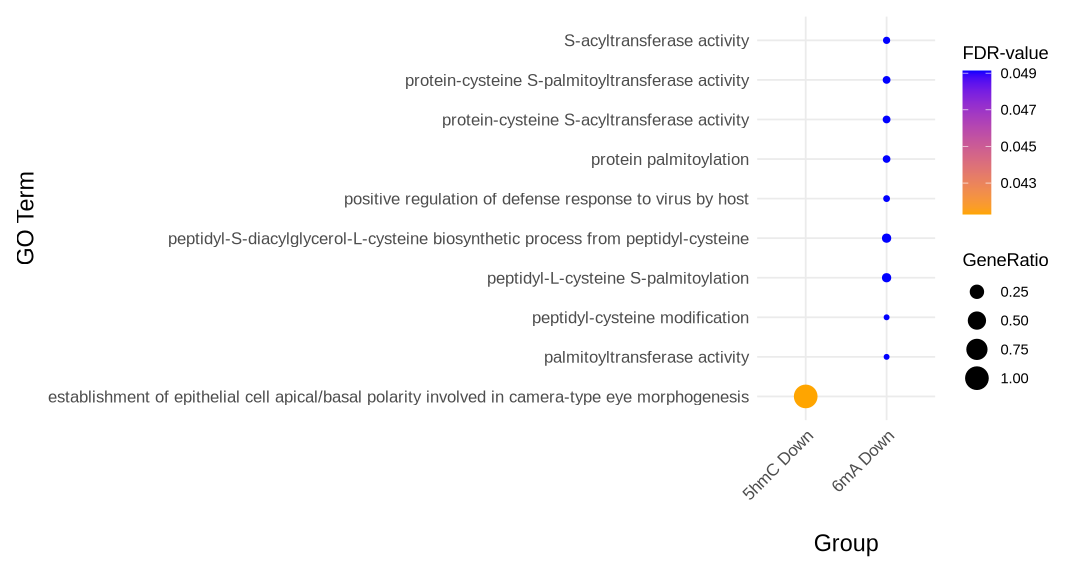

In [29]:
bubble_df_go <- data.frame()
groups = c("all_tests", "Amods_up", "Amods_down", "hmCmods_up", "hmCmods_down", "mCmods_up", "mCmods_down")
for (group_name in groups) {
    go_path = paste0(group_name, ".go_annotation_results.20250507.tsv")
    go_results = read.csv(go_path, sep = "\t")
    print(dim(go_results))
    if (dim(go_results)[1] == 0) {
        next
    }
    go_results$GeneRatio <- go_results$DE / go_results$N
    go_results$Group <- group_name
    bubble_df_go <- rbind(bubble_df_go, go_results)
}

# restrict to FDR < 0.05
# bubble_df_go_sig_2 = bubble_df_go[bubble_df_go$"FDR_adjusted" < 0.05, ]   # done already

# Replace "old" with "new" in column 'your_column'
bubble_df_go_sig_2 = bubble_df_go
bubble_df_go_sig_2$Group <- gsub("all_tests", "All Contexts", bubble_df_go_sig_2$Group)
bubble_df_go_sig_2$Group <- gsub("Amods_down", "6mA Down", bubble_df_go_sig_2$Group)
bubble_df_go_sig_2$Group <- gsub("hmCmods_up", "5hmC Up", bubble_df_go_sig_2$Group)
bubble_df_go_sig_2$Group <- gsub("hmCmods_down", "5hmC Down", bubble_df_go_sig_2$Group)
bubble_df_go_sig_2$Group <- gsub("mCmods_up", "5mC Up", bubble_df_go_sig_2$Group)
bubble_df_go_sig_2$Group <- gsub("mCmods_down", "5mC Down", bubble_df_go_sig_2$Group)

# Create the bubble plot
bubble_df_go_fp = "bubble_df_go.png"
# png(filename = bubble_df_go_fp)
num_groups = length(unique(bubble_df_go_sig_2$Group))
height = 0.12*(dim(bubble_df_go_sig_2)[1]) + 3.5
width = (1.0*num_groups) + 7
options(repr.plot.width = width, repr.plot.height = height)
ggplot(bubble_df_go_sig_2, aes(x = Group, y = Term, size = GeneRatio, color = FDR_adjusted)) +
  geom_point() +
  scale_color_gradient(low = "orange", high = "blue") +
  theme_minimal() +
  labs(x = "Group", y = "GO Term", size = "GeneRatio", color = "FDR-value") +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(angle = 45, vjust = 1.0, hjust = 1, size = 10),
    axis.title.y = element_text(size = 14),
    axis.title.x = element_text(vjust = -4.0, size = 14),
    plot.margin = margin(t = 10, r = 10, b = 20, l = 10) # increase bottom (b)
  )
# dev.off()
# )


In [37]:
bubble_df_go_sig_2

,Term,Ont,N,DE,P.DE,FDR_adjusted,GeneRatio,Group
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
GO:0018198,peptidyl-cysteine modification,BP,36,1,0.0034544774,0.04913035,0.02777778,6mA Down
GO:0002230,positive regulation of defense response to virus by host,BP,33,1,0.0031668326,0.04913035,0.03030303,6mA Down
GO:0018345,protein palmitoylation,BP,27,1,0.0025914184,0.04913035,0.03703704,6mA Down
GO:0018230,peptidyl-L-cysteine S-palmitoylation,BP,16,1,0.0015360612,0.04913035,0.06250000,6mA Down
GO:0018231,peptidyl-S-diacylglycerol-L-cysteine biosynthetic process from peptidyl-cysteine,BP,16,1,0.0015360612,0.04913035,0.06250000,6mA Down
GO:0016409,palmitoyltransferase activity,MF,36,1,0.0034544774,0.04913035,0.02777778,6mA Down
GO:0016417,S-acyltransferase activity,MF,30,1,0.0028791463,0.04913035,0.03333333,6mA Down
GO:0019706,protein-cysteine S-palmitoyltransferase activity,MF,26,1,0.0024954999,0.04913035,0.03846154,6mA Down
GO:0019707,protein-cysteine S-acyltransferase activity,MF,26,1,0.0024954999,0.04913035,0.03846154,6mA Down


In [41]:
add_gene_ids <- function(all_test_top, input_genes, group_name, kegg_test=FALSE) {
    # group_names = c("All tests", "Increased 6mA", "Decreased 6mA", "Increased 5hmC", "Decreased 5hmC", "Increased 5mC", "Decreased 5mC")
    # groups = list(genes_from_all_tests, genes_from_Amods_up, genes_from_Amods_down, genes_from_hmCmods_up, genes_from_hmCmods_down, genes_from_mCmods_up, genes_from_mCmods_down)

    results_df <- data.frame()

    # for (i in seq_along(group_names)) {
    # group_name <- group_names[i]
    # input_df <- groups[[i]]

    for (go_key in rownames(all_test_top)) {
        skip <- FALSE
        go_desc <- all_test_top[go_key, "Term"]
        x <- org.Hs.egGO2ALLEGS

        # try the risky assignment
        tryCatch(
            {
                Rkeys(x) <- go_key
            },
            error = function(e) {
                #   message("Error processing item: ", e$message)
                skip <<- TRUE
            }
        )

        if (skip) next

        go_term_allgenes <- mappedLkeys(x)
        print(go_term_allgenes)
        print(input_genes)
        my_entrezids <- intersect(go_term_allgenes, input_genes)
        if (length(my_entrezids) == 0) {
            next
        }

        matching_genes <- genes_from_all_tests_geneIDs %>%
            filter(EntrezID %in% my_entrezids)

        temp_df <- matching_genes %>%
            mutate(GO_Term = go_key, GO_Description = go_desc) %>%
            select(GO_Term, GO_Description, everything())

        temp_df$EntrezID <- NULL
        temp_df$TestDescription <- group_name

        results_df <- bind_rows(results_df, temp_df)
    }
    return(results_df)
}



[1] 0 5
[1] 0 5
[1] 1 5
[1] 0 5
[1] 0 5
[1] 12  5
[1] 0 5


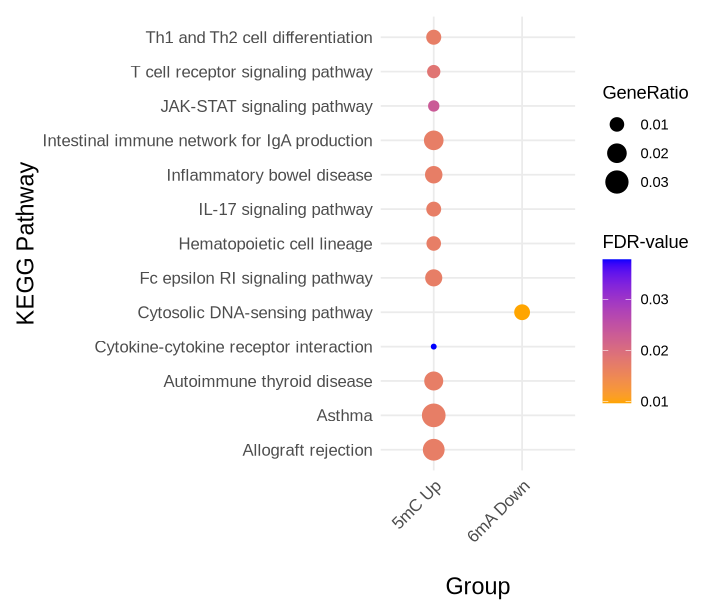

In [35]:
bubble_df_kegg <- data.frame()
groups = c("all_tests", "Amods_up", "Amods_down", "hmCmods_up", "hmCmods_down", "mCmods_up", "mCmods_down")
for (group_name in groups) {
    go_path = paste0(group_name, ".kegg_annotation_results.20250507.tsv")
    go_results = read.csv(go_path, sep = "\t")
    print(dim(go_results))
    if (dim(go_results)[1] == 0) {
        next
    }
    go_results$GeneRatio <- go_results$DE / go_results$N
    go_results$Group <- group_name
    bubble_df_kegg <- rbind(bubble_df_kegg, go_results)
}

# restrict to FDR < 0.05
# bubble_df_go_sig_2 = bubble_df_go[bubble_df_go$"FDR_adjusted" < 0.05, ]   # done already

# Replace "old" with "new" in column 'your_column'
bubble_df_kegg_sig_2 = bubble_df_kegg
bubble_df_kegg_sig_2$Group <- gsub("all_tests", "All Contexts", bubble_df_kegg_sig_2$Group)
bubble_df_kegg_sig_2$Group <- gsub("Amods_down", "6mA Down", bubble_df_kegg_sig_2$Group)
bubble_df_kegg_sig_2$Group <- gsub("hmCmods_up", "5hmC Up", bubble_df_kegg_sig_2$Group)
bubble_df_kegg_sig_2$Group <- gsub("hmCmods_down", "5hmC Down", bubble_df_kegg_sig_2$Group)
bubble_df_kegg_sig_2$Group <- gsub("mCmods_up", "5mC Up", bubble_df_kegg_sig_2$Group)
bubble_df_kegg_sig_2$Group <- gsub("mCmods_down", "5mC Down", bubble_df_kegg_sig_2$Group)

# Create the bubble plot
bubble_df_go_fp = "bubble_df_go.png"
# png(filename = bubble_df_go_fp)
num_groups = length(unique(bubble_df_kegg_sig_2$Group))
height = 0.12*(dim(bubble_df_kegg_sig_2)[1]) + 3.5
width = (1.0*num_groups) + 4
options(repr.plot.width = width, repr.plot.height = height)
ggplot(bubble_df_kegg_sig_2, aes(x = Group, y = Pathway, size = GeneRatio, color = FDR_adjusted)) +
  geom_point() +
  scale_color_gradient(low = "orange", high = "blue") +
  theme_minimal() +
  labs(x = "Group", y = "KEGG Pathway", size = "GeneRatio", color = "FDR-value") +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(angle = 45, vjust = 1.0, hjust = 1, size = 10),
    axis.title.y = element_text(size = 14),
    axis.title.x = element_text(vjust = -4.0, size = 14),
    plot.margin = margin(t = 10, r = 10, b = 20, l = 10) # increase bottom (b)
  )
# dev.off()
# )


In [36]:
bubble_df_kegg_sig_2

,Pathway,N,DE,P.DE,FDR_adjusted,GeneRatio,Group
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
hsa04623,Cytosolic DNA-sensing pathway,83,1,0.009712146,0.009712146,0.012048193,6mA Down
hsa04640,Hematopoietic cell lineage,100,1,0.011701381,0.016901994,0.010000000,5mC Up
hsa04657,IL-17 signaling pathway,95,1,0.011116312,0.016901994,0.010526316,5mC Up
hsa04658,Th1 and Th2 cell differentiation,93,1,0.010882284,0.016901994,0.010752688,5mC Up
hsa04664,Fc epsilon RI signaling pathway,69,1,0.008073953,0.016901994,0.014492754,5mC Up
hsa04672,Intestinal immune network for IgA production,50,1,0.005850690,0.016901994,0.020000000,5mC Up
hsa05310,Asthma,32,1,0.003744442,0.016901994,0.031250000,5mC Up
hsa05320,Autoimmune thyroid disease,54,1,0.006318746,0.016901994,0.018518519,5mC Up
hsa05321,Inflammatory bowel disease,66,1,0.007722911,0.016901994,0.015151515,5mC Up
